# Load Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load to GPU

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# # Make only selected GPUs visible 
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import glob
import random
from keras.models import *

from keras.layers import Input, merge, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, Cropping2D, Concatenate, BatchNormalization

from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from keras.preprocessing.image import img_to_array, load_img

# Assummed directory structure 
# 
# +- images 
# |
# +- masks +- 0
#           +- 1
#           ...
#           +- n
# 
# Number of labels is determined by presence of subdirectories in "masks". 

# Mac/Linux
image_dir = '/content/drive/My Drive/training/testcases/images'
labels_dir = '/content/drive/My Drive/training/testcases/masks'

# Windows
# image_dir = 'C:\\Users\\Honson\\Desktop\\notebook\\catheterLabels\\set1\\images'
# labels_dir = 'C:\\Users\\Honson\\Desktop\\notebook\\catheterLabels\\set1\\masks'

# Google Colab
# same as linux

# Change resolution image accordingly
height = 512
width = 512
color_space = "grayscale" # "grayscale" or "rgb"

# Set number of input channels based on the selected colorspace
if color_space == "grayscale":
    n_channels = 1
elif color_space == "rgb":
    n_channels = 3

# Get parameters of the input and output from images and labels 
images = glob.glob(image_dir+'/*')
labels = glob.glob(labels_dir+'/*')
print(labels)

n_images = len(images)
n_classes = len(labels)

print('Number of images : ', n_images)
print('Number of channels : ', n_channels)
print('Number of classes :', n_classes)
print('Image height : ', height)
print('Image width :', width)

data_images = np.ndarray((n_images, height, width, n_channels), dtype=np.uint8)
data_labels = np.ndarray((n_images, height, width, n_classes), dtype=np.uint8)

print(data_images.shape)
print(data_labels.shape)

idx = 0
for i in images:
    
    # Read image
    fn = i
    
    # Convert to desired color space 
    img = load_img(fn, color_mode = color_space, target_size=(height, width))
    img = img_to_array(img)

    # Put in the data_images array
    data_images[idx] = img
    
    # Look for labels for this image, read and put in the data_labels array
    # Take note that this starts from 0 and goes to n. The labels must be labeled in this sense.
    for j in range(0, n_classes):

        img_fn = fn.split('/')[-1]
        
        # label_fn = labels_dir+'/'+str(j)+'/'+img_fn
        label_fn = labels_dir+'/'+str(1)+'/'+img_fn # fixed because we started with 1
        #print('Our label fn is:')
        #print(label_fn)
        
        # If file label_fn exists read
        if os.path.exists(label_fn):
            
            label = load_img(label_fn, color_mode = "grayscale", target_size=(height, width))
            label = img_to_array(label)
            label = np.reshape(label, (height, width))
        
            data_labels[idx,:,:,j] = label
            
        else:
            data_labels[idx,:,:,j] = 0
    
    idx = idx + 1

    
data_images = data_images.astype('float32')
data_labels = data_labels.astype('float32')
data_images /= 255
data_labels /= 255
data_labels[data_labels > 0.5] = 1
data_labels[data_labels <= 0.5] = 0

Using TensorFlow backend.


['/content/drive/My Drive/training/testcases/masks/1']
Number of images :  4
Number of channels :  1
Number of classes : 1
Image height :  512
Image width : 512
(4, 512, 512, 1)
(4, 512, 512, 1)


# Define U-Net

In [0]:
# Define the U-net network 

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def unet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    
    model = Model(inputs=i, outputs=o)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [4]:
from keras.layers import Convolution2D as Conv2D
from keras.layers.convolutional import Deconv2D as Conv2DTranspose

# Initialize the Unet model.
model = unet((height, width, n_channels), 
             out_ch=n_classes, 
             depth=4, 
             inc_rate=2., 
             activation="relu", 
             dropout=True, 
             batchnorm=False, 
             maxpool=True, 
             upconv=True, 
             residual=False)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# Load in weights
model.load_weights('/content/drive/My Drive/training/model/catheter-detect.h5')

# Validation & Predictions

In [6]:
# Take in sample set and initialize variables
n = 4

test_data = np.ndarray((n, height, width, n_channels), dtype=np.uint8)
    
for i in range(len(images)):

    test_image = images[i]
    img = load_img(test_image, color_mode = 'grayscale', target_size=(height, width))

    img = img_to_array(img)

    test_data[i] = img

print('This is the test_data shape')
print(test_data.shape)
print()

# Convert to float and normalize
test_data = test_data.astype('float32')
test_data /= 255

print("running test inference")
img_mask = model.predict(test_data, batch_size=5, verbose=1)
print(img_mask.shape)
print("test ok")

This is the test_data shape
(4, 512, 512, 1)

running test inference
4/4 [==============================] - 9s 2s/step
(4, 512, 512, 1)
test ok


In [7]:
 import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" 
 
# Do other imports now...
import keras


# Take this and run evaluation
model.evaluate(data_images, data_labels, verbose=1)
        

4/4 [==============================] - 1s 126ms/step


[0.367201030254364, 0.9619979858398438]

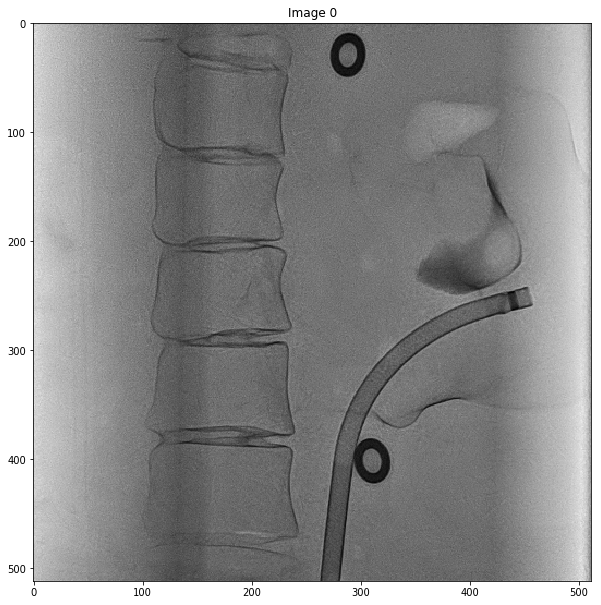

Model output


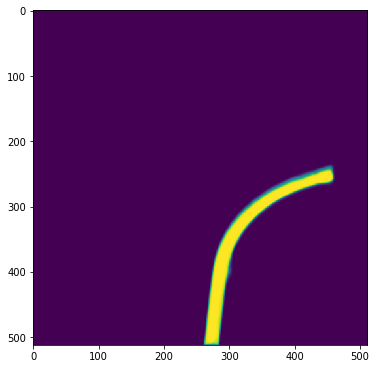

Ground truth


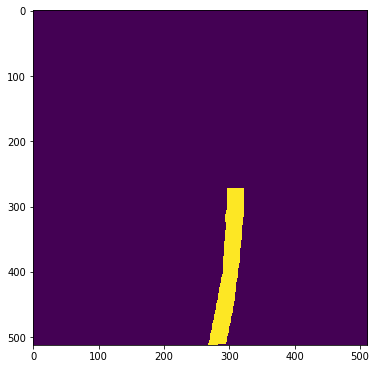

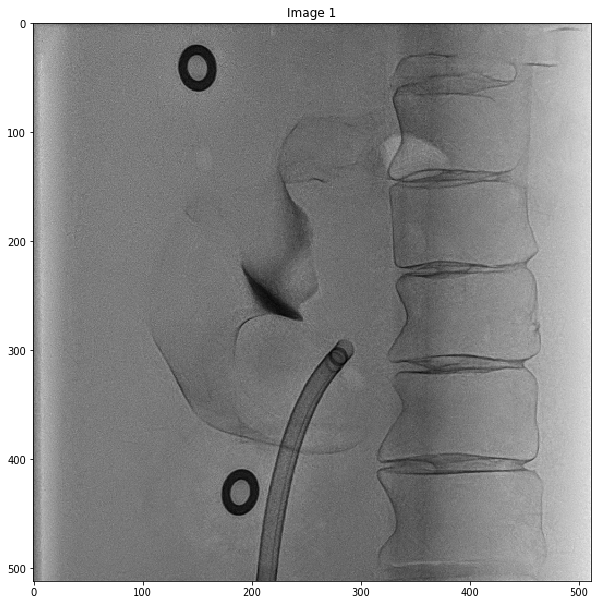

Model output


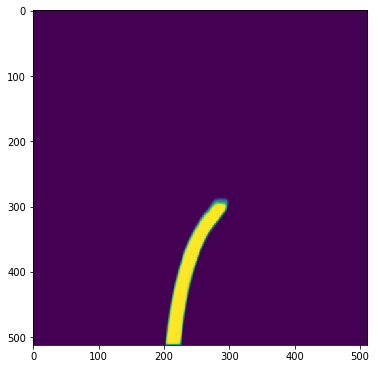

Ground truth


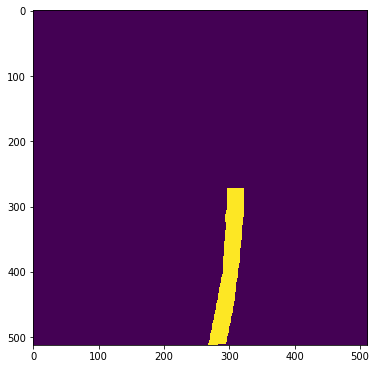

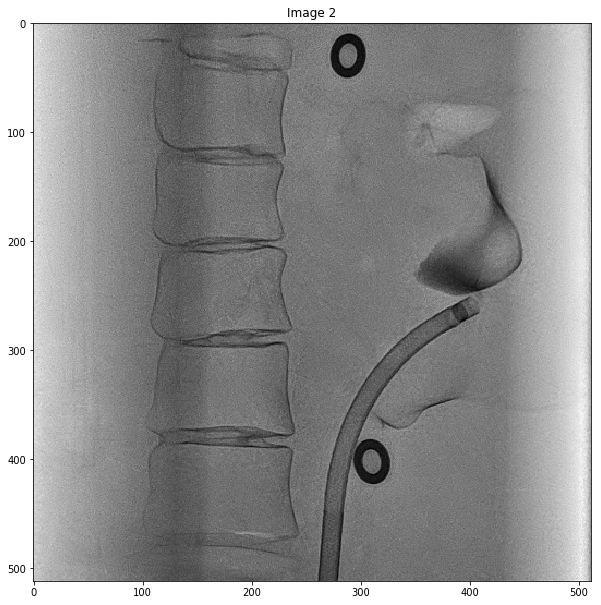

Model output


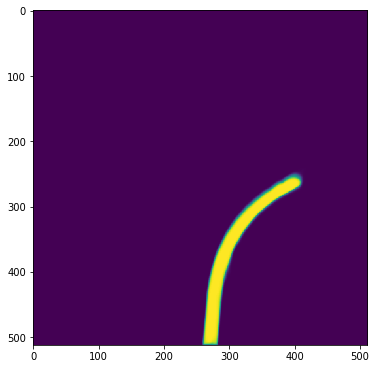

Ground truth


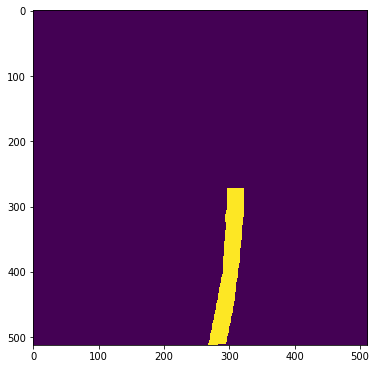

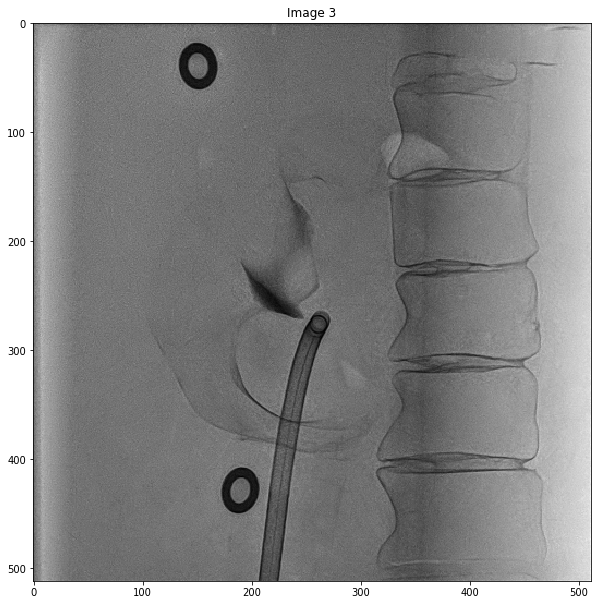

Model output


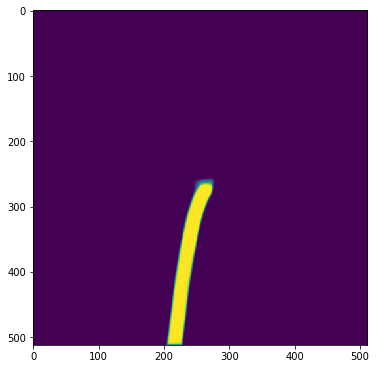

Ground truth


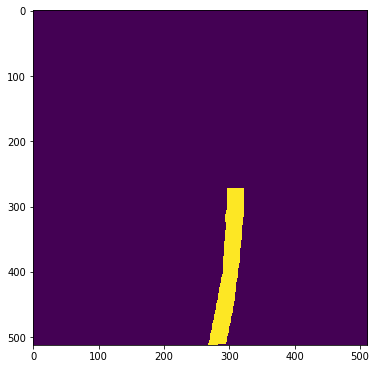

In [8]:
import math

img_per_row = 3
n_rows = math.ceil(n_classes/img_per_row) + 1

for i in range(len(images)):
    plt.rcParams["figure.figsize"] = (10,20)
    plt.title('Image ' + str(i))
    plt.imshow(test_data[i,:,:,0], "gray")
    plt.show()
    
    print('Model output')
    plt.rcParams["figure.figsize"] = (15,30)
    f1 = plt.figure()

    # Loop over classes
    for k in range(0,n_classes):

        f1.add_subplot(n_rows, img_per_row, k+1)
        plt.imshow(img_mask[i,:,:,k])

    plt.tight_layout()
    plt.show()


    print('Ground truth')
    plt.rcParams["figure.figsize"] = (15,30)
    f2 = plt.figure()

    # Loop over classes
    for k in range(0,n_classes):

        f2.add_subplot(n_rows, img_per_row, k+1)
        plt.imshow(data_labels[i,:,:,k])

    plt.tight_layout()
    plt.show()